In [2]:
import pandas as pd

df = pd.read_csv('../data/interim/feature_engineered_data.csv')
X = df.drop('Class', axis=1)
y = df['Class']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [4]:
weight = (len(y_train) - sum(y_train)) / sum(y_train)
print(f"scale_pos_weight: {weight:.2f}")


scale_pos_weight: 599.02


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

xgb = XGBClassifier(
    scale_pos_weight=weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)


y_proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.05).astype(int)



c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")


[[84948    28]
 [   30   112]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.80      0.79      0.79       142

    accuracy                           1.00     85118
   macro avg       0.90      0.89      0.90     85118
weighted avg       1.00      1.00      1.00     85118

AUC: 0.9743


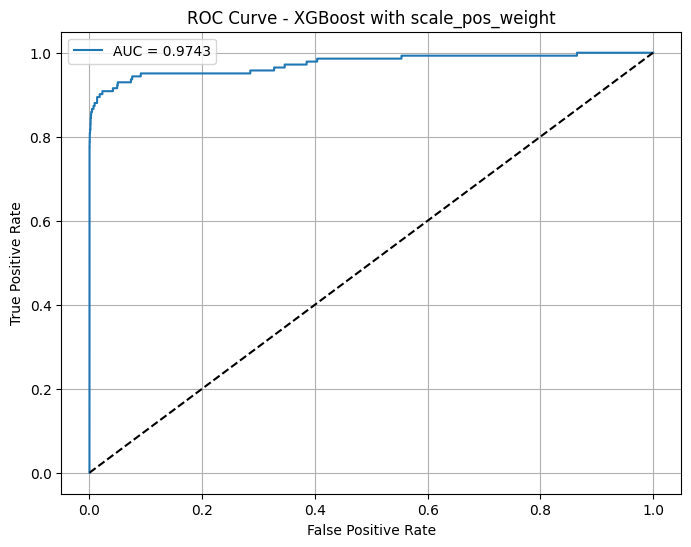

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost with scale_pos_weight")
plt.legend()
plt.grid()

# Save to reports/figures
plt.savefig('../reports/figures/roc_curve.png')
plt.show()


<Figure size 1000x600 with 0 Axes>

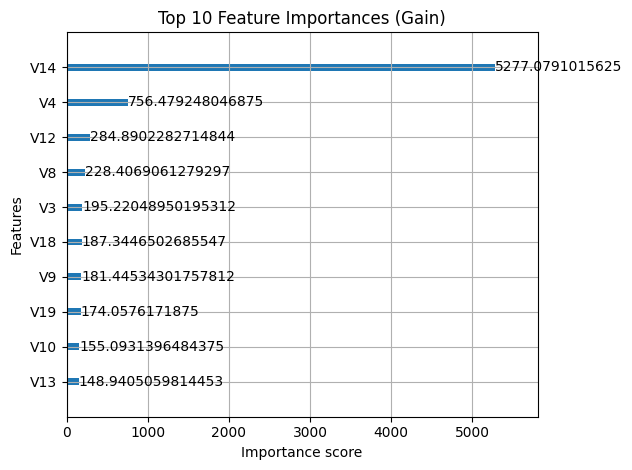

['../models/xgb_fraud_final_model.pkl']

In [14]:
from xgboost import XGBClassifier, plot_importance
import joblib
# Plot & save feature importance
plt.figure(figsize=(10,6))
plot_importance(xgb, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.tight_layout()
plt.savefig("../reports/feature_importance.png")
plt.show()

# Save model
joblib.dump(xgb, "../models/xgb_fraud_final_model.pkl")